In [12]:
#Let's import the necessary packages:
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
tqdm.pandas() 
import random
from transformers import GPT2Tokenizer
from transformers import AdamW, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import GPT2LMHeadModel, TrainingArguments, Trainer, AdamW
from peft import get_peft_model, LoraConfig, TaskType
import peft
from sklearn.model_selection import train_test_split
import wandb
from rouge_score import rouge_scorer
import evaluate
from transformers import T5Tokenizer, T5ForConditionalGeneration

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

In [2]:
df = pd.read_csv("sampled_conversational_data.csv")

In [3]:
df.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,169,1,My insurance does not cover PMS,my insurance does not cover PMS
1,169,2,Then tell them I had a seizure.,then tell them i had a seizure
2,169,3,Is this about Sarah Lawrence? You punishing me?,is this about Sarah Lawrence you punishing me
3,169,4,I thought you were punishing me.,i thought you were punishing me
4,169,5,Why can't we agree on this?,why can not we agree on this


In [4]:
df.shape

(7126, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7126 entries, 0 to 7125
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Conversation ID  7126 non-null   int64 
 1   Turn ID          7126 non-null   int64 
 2   Text             7126 non-null   object
 3   cleaned_text     7126 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.8+ KB


In [6]:
# Show the unique count of 'Conversation ID':
df['Conversation ID'].nunique()




714

Token Length Statistics:
count    714.000000
mean     141.275910
std       58.457866
min       19.000000
25%       99.000000
50%      131.000000
75%      175.000000
max      412.000000
Name: token_length, dtype: float64


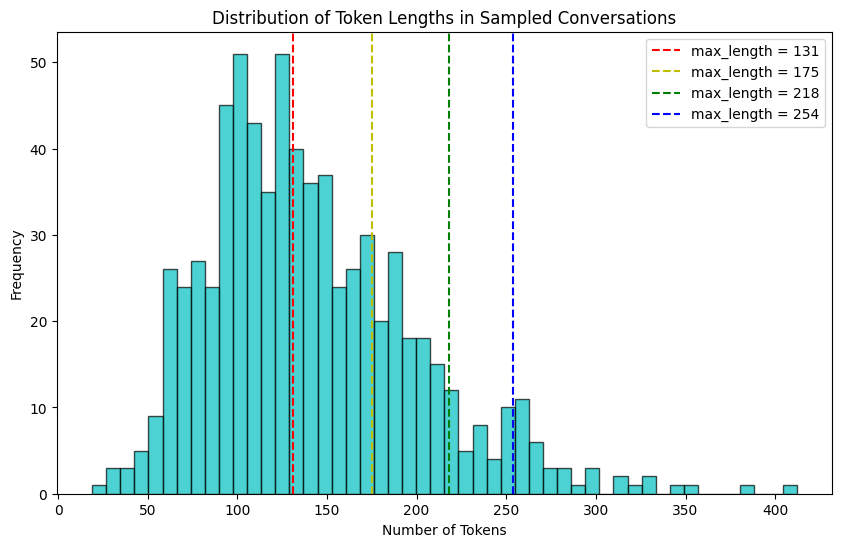

Token Length Percentiles:
0.50    131.00
0.75    175.00
0.90    218.00
0.95    254.35
Name: token_length, dtype: float64


In [8]:

# Load the T5 tokenizer:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Concatenate all conversation turns into a single string per conversation for token length analysis:
all_conversations_text = df.groupby('Conversation ID')['cleaned_text'].apply(lambda x: " ".join(x)).tolist()

# Calculate the number of tokens for each conversation:
conversation_token_lengths = [len(tokenizer.tokenize(convo)) for convo in all_conversations_text]

# Create a DataFrame for analysis:
df_lengths = pd.DataFrame({'conversation': all_conversations_text, 'token_length': conversation_token_lengths})

# Display basic statistics about token lengths:
print("Token Length Statistics:")
print(df_lengths['token_length'].describe())

# Plot the distribution of token lengths:
plt.figure(figsize=(10, 6))
plt.hist(df_lengths['token_length'], bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Distribution of Token Lengths in Sampled Conversations')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=131, color='r', linestyle='--', label='max_length = 131')
plt.axvline(x=175, color='y', linestyle='--', label='max_length = 175')
plt.axvline(x=218, color='g', linestyle='--', label='max_length = 218')
plt.axvline(x=254, color='b', linestyle='--', label='max_length = 254')
plt.legend()
plt.show()

# Calculate percentiles to understand token coverage:
percentiles = df_lengths['token_length'].quantile([0.5, 0.75, 0.9, 0.95])
print("Token Length Percentiles:")
print(percentiles)


**Summary Highlights:**
* **Median Token Length (50th Percentile):** `131 tokens` This means that half of the conversations have fewer than `131` tokens.
* **75th Percentile Token Length:** `175 tokens` `75%` of the conversations have fewer than `175` tokens.
* **90th Percentile Token Length:** `218 tokens` `90%` of the conversations have fewer than `218` tokens, which suggests that a max length of around `218` would cover most of the data.
* **95th Percentile Token Length:** `254.35 tokens` `95%` of conversations have fewer than `254.35` tokens, indicating that only a small portion of conversations would exceed this length.

**Visual Insight:**

* **Max Length of 131 Tokens:** This length covers a bit more than `50%` of the conversations.
* **Max Length of 218 Tokens:** This covers approximately `90%` of the conversations, making it a strong candidate for efficient training.
* **Max Length of 254 Tokens:** Covers almost all conversations but might result in higher memory usage.

**Recommendation:**
Based on the analysis, a max token length of `175` strikes a good balance between covering a majority of the conversations `(75%)` and keeping the input manageable for T5-Small fine-tuning, making it a practical choice for training on limited resources.

In [9]:
# Load the tokenizer :
tokenizer = T5Tokenizer.from_pretrained('t5-small')


tokenizer.pad_token = tokenizer.eos_token

# Tokenize the `cleaned_text` column
df['input_ids'] = df['cleaned_text'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=180, padding='max_length')
)

# Inspect the first few rows after tokenization
df[['cleaned_text', 'input_ids']].head()


,cleaned_text,input_ids
0,my insurance does not cover PMS,"[82, 958, 405, 59, 1189, 3246, 134, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
1,then tell them i had a seizure,"[258, 817, 135, 3, 23, 141, 3, 9, 4736, 1000, 60, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
2,is this about Sarah Lawrence you punishing me,"[19, 48, 81, 8077, 16617, 25, 24584, 53, 140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
3,i thought you were punishing me,"[3, 23, 816, 25, 130, 24584, 53, 140, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
4,why can not we agree on this,"[572, 54, 59, 62, 2065, 30, 48, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"


In [10]:
# Group the data by Conversation ID to create input-output pairs:
def create_input_output_pairs(df):
    conversation_pairs = []
    
    grouped_conversations = df.groupby('Conversation ID')
    
    for _, group in grouped_conversations:
        group = group.sort_values(by='Turn ID')
        for i in range(len(group) - 1):
            input_text = group.iloc[i]['input_ids']
            response_text = group.iloc[i + 1]['input_ids']
            conversation_pairs.append((input_text, response_text))
    
    return conversation_pairs

# Create conversation pairs:
conversation_pairs = create_input_output_pairs(df)

In [13]:
class ConversationDataset(Dataset):
    def __init__(self, conversation_pairs, max_length=180):
        self.data = conversation_pairs
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_text, response_text = self.data[idx]
        return {
            'input_ids': torch.tensor(input_text, dtype=torch.long),
            'labels': torch.tensor(response_text, dtype=torch.long)
        }

# Instantiate the dataset:
dataset = ConversationDataset(conversation_pairs)

In [14]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets:
train_data, val_data = train_test_split(dataset, test_size=0.2)

# Create DataLoaders for training and validation:
from torch.utils.data import DataLoader

batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)


In [15]:
# Load the pre-trained T5 model:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Set padding token if not defined:
model.config.pad_token_id = model.config.eos_token_id


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
# Set up the LoRA configuration:
lora_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.1,
    target_modules=["q", "v"]  # Applying LoRA on attention layers
)

# Apply LoRA to the model:
model = get_peft_model(model, lora_config)


In [17]:
# Define optimizer with weight decay:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
lr = 1e-3 # Higher learning rate compared to Full fine tuning. Lora is at lower risk of overfiting 
num_epochs = 3

use_wandb = True
wandb_run_name = "BERT_MultiClass_w_Lora"

# Define training arguments with all the parameters you mentioned
training_args = TrainingArguments(
    output_dir='./T5_Multi_Classs',  # Output directory for model checkpoints
    learning_rate=lr,  # Learning rate (ensure `lr` is defined before use)
    do_train=True,  # Enable training
    do_eval=True,  # Enable evaluation
    num_train_epochs=num_epochs,  # Number of training epochs (ensure `num_epochs` is defined)
    per_device_train_batch_size=34,  # Batch size for training
    per_device_eval_batch_size=32,  # Batch size for evaluation
    weight_decay=0.1,  # Weight decay to prevent overfitting
    logging_strategy='steps',  # Log metrics every few steps
    logging_dir='./T5_logs',  # Directory to save logs
    logging_steps=50,  # Number of steps between logs
    evaluation_strategy="steps",  # Evaluate model every few steps
    eval_steps=100,  # Number of steps between evaluations
    save_strategy="steps",  # Save model checkpoints every few steps
    save_steps=500,  # Number of steps between saving checkpoints
    save_total_limit=2,  # Keep only 2 checkpoints at a time
    fp16=False,  # Disable mixed precision (set to False to avoid issues)
    load_best_model_at_end=True,  # Load the best model at the end of training
    report_to="wandb",  # Report metrics to Weights and Biases
    #run_name=wandb_run_name if use_wandb else None  # Use a custom run name for WandB if enabled
)

C:\Users\aktha\anaconda3\envs\tf_env\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Initialize WandB:
wandb.init(project="t5-lora-chatbot")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aktham-momani81 (aktham-momani81-university-of-san-diego). Use `wandb login --relogin` to force relogin


In [22]:
# Use the evaluate library for BLEU and ROUGE:
import evaluate

# Load BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Define custom compute_metrics function
def compute_metrics(pred):
    # Get the predicted token ids
    preds = pred.predictions
    labels = pred.label_ids
    
    # Convert predicted token ids and labels to strings
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # BLEU score
    bleu_results = bleu_metric.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])
    
    # ROUGE score
    rouge_results = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {
        'bleu': bleu_results['bleu'],
        'rouge1': rouge_results['rouge1'].mid.fmeasure,
        'rougeL': rouge_results['rougeL'].mid.fmeasure,
    }


In [27]:

# Initialize the Trainer with the model, data, and custom metrics:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Use train_data dataset directly
    eval_dataset=val_data,  # Use val_data dataset directly
    optimizers=(optimizer, None),  # AdamW optimizer
    compute_metrics=compute_metrics  # Custom metrics like BLEU and ROUGE
)


In [28]:
# Train the model
trainer.train()


Step,Training Loss,Validation Loss


KeyboardInterrupt: 